# 制限従属変数モデル

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import wooldridge
from see import see
from py4etrics.truncreg import Truncreg
from py4etrics.tobit import Tobit
from py4etrics.heckit import Heckit
from py4etrics.hetero_test import het_test_probit

ModuleNotFoundError: No module named 'py4etrics'

## 説明

**制限従属変数**（Limited Dependent Variables; LDV）とは，被説明変数が取り得る値が大きく制限される場合を指す。`Logit`と`Probit`も制限従属変数の例であり，被説明変数は$(0,1)$に制限されている。この章では，違ったタイプの制限従属変数を考える。

データの性質上２つに分けることができる。
1. 切断データ（Truncated Data）
    * 特定のデータが標本に含まれていない。
    * 例：平成30年度「環境にやさしい企業行動調査」の調査対象企業は，従業員数500名以上となっており，500名未満の企業は含まれていない。
1. 打ち切りデータ（Censored Data）
    1. 端点解の場合
        * 募金の金額の例：募金しない場合は０円だが，募金する人の額は正の値を取る。（下からの打ち切りデータ）
    1. データ制約の場合
        * 所得調査の例：Ｘ万円からＹ万円のようにカテゴリーでまとめる場合が通常であり，最高額カテゴリーはＺ万円以上のようになる。この場合，Ｚ万円以上の所得は全てＺ万円となる。（上からの打ち切りデータ）

（コメント）以下のようにも呼ばれる
* **下から**の打ち切りデータ ＝ **左から**の打ち切りデータ（left-censored）
* **上から**の打ち切りデータ ＝ **右から**の打ち切りデータ（right-censored）

---
データの性質に分けて次のモデルの使い方を説明する。
* 切断回帰モデル（Truncated Regression）：切断データ
* Tobitモデル：打ち切りデータ
* Heckitモデル：切断データで選択バイアス問題が発生する場合

## 切断回帰モデル

### 説明

無作為な形ではなく，ある特定の一部のデータが標本から欠らくしている切断データの分析を考える。例として，女性の労働供給を考えよう。

$$
\begin{align*}
&y_i=\beta_0+\beta_1x_i+u_i\qquad i\in\cal{Y}\\
&(y_i,x_i)\text{は観察されない}\qquad i\in\cal{N}
\end{align*}
$$

* $\cal{Y}$：観測されたデータの集合（通常，無作為に選択されないと考える）。
* $\cal{N}$：観測されないデータの集合（通常，無作為に選択されないと考える）。
* $x$：労働供給に関する決定要因（例えば，教育年数）
* $u|x\sim \text{Normal}(0,\sigma^2)$：労働供給に関するランダムな要素（例えば，好み）
    * この仮定が非常に重要であり計算の前提となる。
* $y_i$：実際の労働供給（非負の連続変数）

＜＜結果＞＞
* 標本集合$\cal{Y}$は無作為標本ではない。従って，GM仮定２が満たされないためOLS推定量$\hat{\beta}_{\text{ols}}$は不偏性を満たさない。また一致性も満たさない。

---
まずシミュレーションを使ってこの結果を直感的に確認する。

### シミュレーション

In [2]:
# 標本の大きさ 
n = 100

# y*を決定するx
x = np.sort(norm.rvs(0,3,size=n))  # ランダム変数を生成し昇順に並べる

# 被説明変数
y = 1 + x + norm.rvs(0,3,size=n)

# DataFrame
df = pd.DataFrame({'Y':y, 'Y_trunc':y, 'X':x})

# 閾値
left = 0

# 切断データの作成
cond = (df.loc[:,'Y'] <= left)
df.loc[cond,'Y_trunc'] = np.nan

# 切断された被説明変数
y_trunc = df['Y_trunc']

ここで`np.nan`とは`NumPy`の定数であり，欠損値`NaN`を示す。`cond`の条件にある閾値`left=0`以下のデータは欠損値として設定されている。`NumPy`には次の定数もあるのでこの機会に紹介する。
* `np.nan`：`NaN`
* `np.inf`：（正の）無限
* `np.e`：$e=2.71...$
* `np.pi`：$\pi=3.14...$

母集団回帰式

In [3]:
formula_full = 'Y ~ X'

result_full=  ols(formula_full, data=df).fit()

b0_full,b1_full = result_full.params

result_full.params

Intercept    1.291366
X            0.962890
dtype: float64

切断データを使ったOLS回帰

In [4]:
formula_trunc = 'Y_trunc ~ X'

result_trunc = ols(formula_trunc, data=df).fit()

b0_trunc, b1_trunc = result_trunc.params

result_trunc.params

Intercept    3.547483
X            0.435301
dtype: float64

比較するために２つの結果を図示する。同じ図に描くために，先に切断データを整理する。

In [5]:
x_trunc = df.dropna(subset=['Y_trunc']).loc[:,'X']  # 説明（１）
x_min = min(x_trunc)  # 説明（２）
x_max = max(x_trunc)  # 説明（３）

（１）`.dropna()`を使って列`Y_trunc`から欠損値がある行を取り除き，列`X`を`x_trun`に割り当てる。

（２）`x_trun`の最小値を設定。

（２）`x_trun`の最大値を設定。

`matplotlib`を使って２つの図を重ねて図示する。

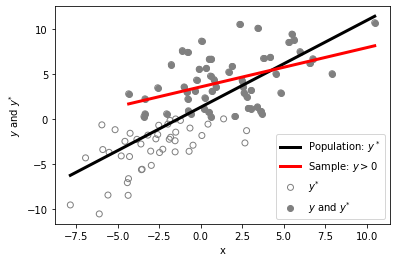

In [6]:
# （１）母集団データの散布図
plt.scatter(x, y, facecolors='none', edgecolors='gray',label=r'$y^{*}$')

# （２）切断データの散布図
plt.scatter(x, y_trunc, facecolors='gray', label=r'$y$ and $y^{*}$')

# 母集団OLS
plt.plot(x, b0_full+b1_full*x, 'k', linewidth=3, label='Population: $y^*$')

# 切断回帰
plt.plot(x_trunc, b0_trunc+b1_trunc*x_trunc, 'r', lw=3,label=r'Sample: $y> 0$')

plt.xlabel('x')
plt.ylabel(r'$y$ and $y^{*}$')
plt.legend()
pass

＜`matplotlib`コードの説明＞

（１）母集団データの散布図
* 引数`facecolors`は全ての観測値の点の色を「なし」に設定する。
* 引数`edgecolors`は全ての観測値の円周をグレーに設定する。
* この２つにより，全ての観測値は左下の観測値のように白抜きのグレーの円として表示される。

（２）切断データの散布図
* 後にくる`plt.plot()`は前にある`plt.plot()`を上書きする。従って，切断データの観測値は母集団データの散布図上に重ねて表示されるため，引数`facecolors`を`gray`に設定することにより切断データだけをグレーの点として表示させることができる。

### 直感的な理解

上の図を見るだけでも切断データによって引き起こされる問題をイメージすることはできるが，以下ではもう一歩踏み込んで推定量のバイアスの理由を直感的に考えてみる。

**＜母集団回帰＞**

母集団回帰式は

$$y=\beta_0+\beta_1 x_1+e\qquad\text{(式１)}$$

であり，全ての観測値をつかう（即ち，切断されたデータがない）場合の条件付き期待値である母集団回帰関数（母集団で平均で成立する回帰線）は

$$\text{E}\left(y|x\right)=\beta_0+\beta_1 x_1\qquad\text{(式２)}$$

となる。

**＜切断回帰＞**

$y>0$のデータだけを使う回帰式は

$$y_i=\beta_0+\beta_1 x_i+u_i\qquad\text{(式３)}$$

となる。標本では$y_i\leq 0$のデータが切断されているため，$y_i>0$を考慮し$x_i$を所与として(式３)の期待値を取ると

$$\text{E}\left(y_i|y_i>0,x_i\right)=\beta_0+\beta_1 x_i+\sigma_u\lambda\left(w_i\right)\qquad\text{(式４)}$$

となる。ここで
* $w_i\equiv\dfrac{A-(\beta_0+\beta_1x_i)}{\sigma}$
* $A$：下限の値（この例では`0`）
* $\sigma_u$：誤差項の標準偏差

となるが，$\sigma_u\lambda\left(w_i\right)$の導出や$\lambda\left(\cdot\right)$の関数形が重要ではない。重要なのは，逆ミルズ比（inverse Mill's ratio）と呼ばれる$\lambda(w_i)\neq 0$の存在であり，$y>0$となる確率の影響を捉えているという点である。(式４)が$y>0$を考慮しているため，(式４)に基づいて次式

$$
y_i=\beta_0+\beta_1 x_i+\sigma_u\lambda\left(w_i\right)+\nu_i\qquad\text{(式５)}
$$

を推定する必要がある。しかし(式３)をOLS推定すると，$\lambda(x)$が欠落することになり，**欠落変数バイアス**が発生することになる。このバイアスは，上の図で黒と赤の回帰線の傾きの違いに現れている。OLS推定量はゼロ方向にバイアスが発生する事が知られている。

### `Truncreg`モジュールの使い方

切断データを扱うために切断回帰モデルを展開する。ここでは，具体的な内容は説明できないが，`Logit`と`Probit`と同じように最尤法をつかい推定する。

* 切断回帰モデルの推定量は一致性を満たす。

---
`statsmodels`も`linearmodels`も`Tobit`推定のモジュールがない。その代わりに著者が作成した`py4etrics`パッケージの関数`trucreg`モジュールを使い推定する。これは`statsmodels`の`GenericMaximumLikelihoodModel`を使い実装したものである。使用する上で[このサイト](https://www.statsmodels.org/devel/examples/notebooks/generated/generic_mle.html)にある次の点に注意する必要がある。
* `R`の推定値と小数点第４位まで同じになるが，標準偏差は小数点第２位までが同じとなる。

````{note}
MacではTerminal、WindowsではGit Bashを使い、次のコマンドで`py4etrics`モジュールはをインストールできる。
```
pip install git+https://github.com/spring-haru/py4etrics.git
```
````


---
＜使い方＞

基本的に`statsmodels`の`ols`と同じだが，追加的な操作とオプションがある。
1. 推定式を決める
```
    formula = 'y ~ 1 + x'
```
1. `Truncreg`の`from_formula`モジュールを使って推定
```
    Truncreg.from_formula(formula, left=<A>, right=<B>, data=<C>).fit()
```

ここで 
* `left`:左切断の値（デフォルトは$-\infty$）
* `right`:右切断の値（デフォルトは$\infty$）
* `deta`:データの指定
* 切断方向の設定：
    * `left`だけに値を設定する場合は左切断回帰（left-truncated）となる。
    * `right`だけに値を設定する場合は右切断回帰（right-truncated）となる。
    * `left`と`right`の両方に値を設定する場合は左右切断回帰（left- and right-truncated）となる。
    * `left`と`right`の両方に値を設定しない場合は通常の最尤推定となる。

### 切断回帰推定

例として`wooldridge`の`HTV`のデータを使い推定する。

In [7]:
htv = wooldridge.data('HTV')
wooldridge.data('HTV',description=True)

name of dataset: htv
no of variables: 23
no of observations: 1230

+----------+---------------------------------+
| variable | label                           |
+----------+---------------------------------+
| wage     | hourly wage, 1991               |
| abil     | abil. measure, not standardized |
| educ     | highest grade completed by 1991 |
| ne       | =1 if in northeast, 1991        |
| nc       | =1 if in nrthcntrl, 1991        |
| west     | =1 if in west, 1991             |
| south    | =1 if in south, 1991            |
| exper    | potential experience            |
| motheduc | highest grade, mother           |
| fatheduc | highest grade, father           |
| brkhme14 | =1 if broken home, age 14       |
| sibs     | number of siblings              |
| urban    | =1 if in urban area, 1991       |
| ne18     | =1 if in NE, age 18             |
| nc18     | =1 if in NC, age 18             |
| south18  | =1 if in south, age 18          |
| west18   | =1 if in west, age 18      

＜目的＞

教育（`educ`）が賃金（`wage`）に与える影響を探る。1991年の時間賃金を対数化した`lwage`を被説明変数として使い，次の説明変数を使う。
* `educ`：1991年までに修了した最高学位の指標
* `abil`：能力を捉える指標
* `exper`：潜在的な労働経験
* `nc`：米国北中部のダミー変数
* `west`：米国西部のダミー変数
* `south`：米国南部のダミー変数
* `urban`：都市部のダミー変数

まずOLS推定を行う。

In [8]:
formula_trunc = 'lwage ~ 1 + educ + abil + exper + nc + west + south + urban'

res_ols = ols(formula_trunc, data=htv).fit()

print(res_ols.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3987      0.185      2.158      0.031       0.036       0.761
educ           0.1037      0.010     10.704      0.000       0.085       0.123
abil           0.0558      0.008      6.565      0.000       0.039       0.072
exper          0.0448      0.007      6.619      0.000       0.032       0.058
nc            -0.1397      0.041     -3.440      0.001      -0.219      -0.060
west          -0.1282      0.049     -2.638      0.008      -0.224      -0.033
south         -0.1227      0.045     -2.742      0.006      -0.210      -0.035
urban          0.2268      0.041      5.589      0.000       0.147       0.306


`educ`の係数は`0.1037`であり，標準誤差は`0.010`。

次に，`wage`が`20`以上の観測値を取り除き，`20`未満のサンプルだけで推計する。

In [9]:
htv_20 = htv.query('wage < 20')  # データの抽出

print(f'切断前の標本数：{len(htv)}')
print(f'切断前の標本数：{len(htv_20)}')
print(f'削除された標本数：{len(htv)-len(htv_20)}')

切断前の標本数：1230
切断前の標本数：1066
削除された標本数：164


164のサンプルが取り除かれた。これにより，ランダムな標本ではなくなっていおり，GM仮定２が満たされていない。

In [10]:
res_ols_20 = ols(formula_trunc,data=htv_20).fit()

print(res_ols_20.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1795      0.174      6.795      0.000       0.839       1.520
educ           0.0579      0.009      6.258      0.000       0.040       0.076
abil           0.0548      0.008      7.168      0.000       0.040       0.070
exper          0.0218      0.006      3.467      0.001       0.009       0.034
nc            -0.1373      0.038     -3.644      0.000      -0.211      -0.063
west          -0.1415      0.045     -3.120      0.002      -0.230      -0.053
south         -0.1176      0.042     -2.833      0.005      -0.199      -0.036
urban          0.1653      0.037      4.525      0.000       0.094       0.237


`educ`の係数は`0.0579`に大きく下落している。切断データをOLS推定すると（ゼロ方向に）バイアスが発生することを示している。

---
次に，切断回帰推定をおこなう。
* 右切断なので`right`に数値を設定する。
* 説明変数が対数化されているため，それに合わせて`right=np.log(20)`とする。

In [11]:
res_trunc = Truncreg.from_formula(formula_trunc,right=np.log(20),data=htv_20).fit()

print(res_trunc.summary().tables[1])

NameError: name 'Truncreg' is not defined

`educ`の係数は`0.1060`になり，切断される前の標本をOLS推定した際の係数と近い。

（コメント）

このように切断回帰は，切断データを使い`y`（賃金）に対する`x`（教育）の効果を推定可能とする。一方で，切断されたデータの中での`y`に対する`x`の効果に興味がある場合，その限界効果の絶対値は$\left|\hat{\beta}_{\text{Truncreg}}\right|$よりも低くなる。

＜`Log(Sigma)`について＞
* 誤差項は正規分布に従うと仮定され，最尤法により変数の係数$\beta$と誤差項の標準偏差$\sigma$が推定される。誤差項の標準偏差の推定値または回帰の標準偏差（`Sigma` = Standard Error of Regression）の対数が`Log(Sigma)`である。

---
`dir()`もしくは`see()`を使い推定結果`res_trunc`の属性とメソッドを確認してみよう。

In [12]:

see(res_trunc)

NameError: name 'res_trunc' is not defined

対数最尤関数の値

In [13]:
res_trunc.llf

NameError: name 'res_trunc' is not defined

疑似決定係数

In [14]:
res_trunc.prsquared

NameError: name 'res_trunc' is not defined

全ての説明変数（定数項以外）が０の場合の推定結果

In [15]:
print(res_trunc.result_null.summary())

NameError: name 'res_trunc' is not defined

### 検定

次に検定方法について説明する。

**Wald検定の例１**

$H_0$：定数項以外の全てのスロープ係数は０

$H_A$：少なくとも１つの係数は０ではない

この検定のために結果のメソッド`wald_test()`を使うが説明変数に含まれている`Log(Sigma)`は残る必要がある。従って，まず定数項と`Log(Sigma)`以外の係数名を`slopes_all`に割り当てる。


In [16]:
slopes_all = res_trunc.model.exog_names[1:-1]

NameError: name 'res_trunc' is not defined

結果`res_trunc`に属性`model`があり，その中に説明変数名の属性`exog_names`を使っている。定数項と最後にくる`Log(Sigma)`を省くために`[1:-1]`を指定している。

In [17]:
# Wald検定
res_trunc.wald_test(slopes_all).summary()

NameError: name 'res_trunc' is not defined

$p$値は非常に低いので`1%`の有意水準でも帰無仮説を棄却できる。同じ結果は次のコードでも示すことができる。

In [18]:
res_trunc.wald_test_all_slopes

NameError: name 'res_trunc' is not defined

２つ目の例を考えよう。

**Wald検定の例２**

$H_0$：`educ`+`abil`$=$`exper`

$H_A$：`educ`+`abil`$\neq$`exper`

次の方法でおこなう。
1. 制約式を文字列で設定する：`educ+abil=exper`
1. 推定結果のメソッド`wald_test`に制約式を引数として実行する。

In [19]:
res_trunc.wald_test('educ+abil=exper').summary()

NameError: name 'res_trunc' is not defined

`1%`の有意水準でも帰無仮説を棄却できる。

### 予測値と残差

次に２つの属性を紹介する。
* `.fittedvalues`：以下の式で与えられる線形の予測値

    $$\hat{y}_i=\hat{\beta}_0+\hat{\beta}_1x_i$$
    
* `.resid`：以下の式で与えられる線形の残差

    $$\hat{u}_i=y_i-\hat{y}_i$$
    
まず予測値の平均・最小値・最大値を計算してみる。

In [20]:
y_hat = res_trunc.fittedvalues

print(f'最小値：{y_hat.min()}\n平均：{y_hat.mean()}\n最大値：{y_hat.max()}')

NameError: name 'res_trunc' is not defined

次に残差を図示する。

In [21]:
u_hat = res_trunc.resid
plt.scatter(y_hat,u_hat)
plt.xlabel('y_hat')
plt.ylabel('u_hat')
pass

NameError: name 'res_trunc' is not defined

データの切断による影響が右上に見て取れる。

In [22]:
from scipy.stats import truncnorm
plt.scatter(htv_20['lwage'],y_hat)
plt.ylim(0,10)
plt.xlim(0,4)

X = res_trunc.fittedvalues
s = res_trunc.params[-1]
right = (np.log(20) - X)/np.exp(s)
imr = truncnorm.logpdf(-X/np.exp(s),a=-np.inf,b=right)
yexp = X-np.exp(s)*imr
plt.plot(htv_20['lwage'],yexp,'or')
# norm.cdf(X, loc=l, scale=s)

NameError: name 'y_hat' is not defined

### 誤差項の仮定について

切断回帰推定は最尤法を使っており，次の仮定が重要な役割を果たしている。

$$u|x\sim N(0,\sigma^2)$$

即ち，説明変数を所与とすると誤差項は正規分布に従い分散は一定であるという仮定である。

正規分布に関しての検定もあるが`py4etrics`には実装されていないので，この仮定の重要性を念頭に置いて推定すること。

次に不均一分散について考える。確かめるためには検定をする必要があるが，`py4etrics`には実装されていない。その代わりに「目安」として，通常の係数の標準偏差と不均一分散頑健標準偏差の変化を調べてみる。

In [23]:
# 通常の標準偏差
tr0 = res_trunc.bse

# 不均一分散頑健標準編
tr1 = Truncreg.from_formula(formula_trunc,right=np.log(20),
                            data=htv_20).fit(cov_type='HC1',disp=False).bse

# 不均一分散頑健標準編を使った場合の標準偏差の変化率（％）
(100*(tr1-tr0)/tr0)[:-1]   # 最後は Log(Sigma) なので省く

NameError: name 'res_trunc' is not defined

標準偏差が減少した変数と増加したし変数がある。特別に大きくないように見えるが，これは目安であることを念頭に置いておく必要がある。

（注意）不均一分散の下での最尤推定
* 推定量は一致性を満たさない
* 標準誤差も一致性を満たさない
    * 不均一分散頑健標準誤差を使うことが推奨されることがあるが（研究論文でもそうする研究者も多い），もともと係数の推定量が一致性を満たさないため，`cov_type`で指定する不均一分散頑健標準誤差の有用性に疑問が残る。（[参照](https://davegiles.blogspot.com/2013/05/robust-standard-errors-for-nonlinear.html)）

## Tobitモデル

### 説明

打ち切りデータを理解するために，切断データと比べて異なる点を説明する。
* 切断データではデータセットに$(x_i,y_i),\;i\in\cal{N}$が存在しないが，打ち切りデータには含まれる。しかし，$y_i$が打ち切りの下限や上限の値と等しくなる。

例として女性の労働供給を考えよう。働いている女性は多いが労働市場から退出している女性も多いのが実状である。言いかえると，女性の労働供給（例えば，一週間の労働時間）は正の値をとるが，労働供給が０の女性も多くいる。これは数式で次のように表すことができる。

$$
\begin{align*}
&y^{*}=\beta_0+\beta_1x+u\\
    &\begin{cases}
    y=y^{*}&\quad\text{if }y^{*}>0\\
    y=0&\quad\text{if }y^{*}\leq0
    \end{cases}
\end{align*}
$$

* $y^{*}$：潜在変数（例えば，効用と考えても良い）
    * $y^{*}>0$の場合に実際に働き，労働供給は$y=y^{*}$となる。
    * $y^{*}\leq 0$の場合に働かないので$y=0$となる。
    * $y^{*}$は観察不可能
* $x$：労働供給に関する決定要因（例えば，教育年数）
* $y$：実際の労働供給（非負の連続変数）
* $u$：労働供給に関するランダムな要素（例えば，好み）

    $$u|x\sim \text{Normal}(0,\sigma^2)$$
    
    * この仮定が非常に重要であり，計算の前提となる。

---
（コメント）
* 上の例では，女性が労働市場に参加するかしないかによって，$y$が正の値もしくは`0`を取る。即ち，`0`が下限になっている。上限の例として，人気歌手のコンサート・チケットがあげられる。チケット数は限られており，売り切れた場合の需要は上限を上回る。また，下限・上限の両方がある場合として大学入試が挙げられる。下限はセンター試験などでの「足切り」であり，上限は定員数でる。
* 労働供給の例では，女性の選択の結果として$y$の値が観察される。これはミクロ経済学でおなじみの端点解の例である。

---
＜＜結果＞＞
* $y>0$と$y=0$の両方のデータを使ったOLS推定量は不偏性・一致性を満たさない。

---
以下ではまずこの結果をシミュレーションを使って示し，解決策について説明する。

### シミュレーション

In [24]:
# データの大きさ 
n = 100

# y*を決定するx
x = np.sort(norm.rvs(0,3,size=n))  # ランダム変数を生成し昇順に並べる

# y*を生成
y_star = x + norm.rvs(0,3,size=n)

# yを生成
y = y_star.copy()  #  copy()はコピーを作るメソッド
y[y_star < 0] = 0  # y_star<0の場合，０を代入する

# DataFrame
df = pd.DataFrame({'Y':y, 'Y_star':y_star, 'X':x})

母集団回帰式

In [25]:
formula_star = 'Y_star ~ X'

result_star= ols(formula_star, data=df).fit()

b0_star,b1_star = result_star.params

print(result_star.params)

Intercept   -0.606831
X            1.020539
dtype: float64


$y\geq 0$を使ったOLS回帰

In [26]:
formula_sample = 'Y ~ X'

result_corner = ols(formula_sample, data=df).fit()

b0_corner, b1_corner = result_corner.params

print(result_corner.params)

Intercept    1.278428
X            0.502662
dtype: float64


図示

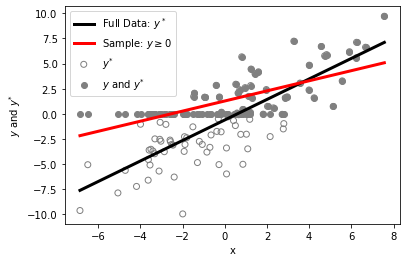

In [27]:
# y_starの散布図
plt.scatter(x, y_star, facecolors='none', edgecolors='gray',label=r'$y^{*}$')

# yの散布図
plt.scatter(x, y, facecolors='gray', label=r'$y$ and $y^{*}$')

# 母集団OLS
plt.plot(x, b0_star+b1_star*x, 'k', linewidth=3, label='Full Data: $y^*$')

# y>=0のOLS
plt.plot(x, b0_corner+b1_corner*x, 'r', lw=3,label=r'Sample: $y\geq 0$')

plt.xlabel('x')
plt.ylabel(r'$y$ and $y^{*}$')
plt.legend()
pass

---
この場合，$y<0$の値を全て$y=0$としてOLS推定しているため，不偏性・一致性が満たされないのは直感的に理解できる。実際，上で説明したように標本回帰式は

$$
\begin{align*}
&y^{*}=\beta_0+\beta_1x+u\\
    &\begin{cases}
    y=y^{*}&\quad\text{if }y^{*}>0\\
    y=0&\quad\text{if }y^{*}\leq0
    \end{cases}
\end{align*}
$$

であるが，$y\geq 0$の下での$y$の期待値 $\text{E}(y|y>0,x)$ は複雑な非線形式なり，線形を仮定するOLS推定方で捉えることは不可能である。

### `Tobit`モジュールの使い方

残念ながら`statsmodels`と`linearmodels`にも`Tobit`推定のモジュールがない。その代わりに著者が作成した`py4etrics`パッケージの`tobit`モジュールを使い推定する。このモジュールは`statsmodels`の`GenericMaximumLikelihoodModel`を使い実装したものである。使用する上で[このサイト](https://www.statsmodels.org/devel/examples/notebooks/generated/generic_mle.html)にある次の点に注意する必要がある。
* `R`の推定値と小数点第４位まで同じになるが，標準偏差は小数点第２位までが同じとなる。

---
＜使い方＞

基本的に`statsmodels`の`ols`と同じだが，追加的な操作とオプションがある。

1. 下限・上限の設定：被説明変数`y`の値に従って`Numpy`の`array`もしくは`Pandas`の`Series`を作る。
    * 下限がある場合：`-1`
    * 上限がある場合：`1`
    * 上限・下限がない場合：`0`
1. 推定式を決める
```
    formula = 'y ~ 1 + x'
```
1. `Tobit`の`from_formula`モジュールを使って推定
```
    Tobit.from_formula(formula, cens=<A>, left=<B>, right=<C>, data=<D>).fit()
```
   ここで 
   
    * `cens`：ステップ１で作成した下限・上限の設定`array`もしくは`Series`を指定する。
    * `left`:下限の値（デフォルトは`0`）
        * ステップ１で`-1`が設定されている場合のみ有効となる。
    * `right`:上限の値（デフォルトは`0`）
        * ステップ１で`1`が設定されている場合のみ有効となる。
    * `deta`:データの指定

（コメント）

`Logit`や`Probit`と同じように，非線形モデルなため最尤法を使い推定する。

### Tobitモデルの推定

以前使った`mroz`のデータを使う。

In [28]:
mroz = wooldridge.data('mroz')

女性の労働供給のモデルを考え，供給量`hours`を被説明変数とする。特に，`hours`は`0`が下限となっているため`Tobit`モデルが妥当だと考えられる。労働時間`hours`を図示すると`0`に多くの観測値があることがわかる。

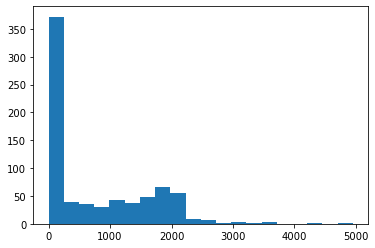

In [29]:
plt.hist(mroz['hours'],bins=20)
pass

まず，下限の値を設定する。

In [30]:
left = 0

次に下限を示す`array`を作成する。

In [31]:
cond = (mroz['hours'] == left)  #  フィルターの作成

censor = np.zeros((len(mroz)))  # 0のarrayの作成

censor[cond] = -1  #  条件に合わせて-1を代入

pd.Series(censor).value_counts()  # Serieに変換し，内訳の確認

 0.0    428
-1.0    325
dtype: int64

次のコードでも同じ結果を得ることができる。

In [32]:
censor = mroz['hours'].apply(lambda x: -1 if x==left else 0)

推定

In [33]:
formula = 'hours ~ 1 + nwifeinc + educ + exper + expersq + age + kidslt6 + kidsge6'

res_tobit = Tobit.from_formula(formula,cens=censor,left=0,data=mroz).fit()

print(res_tobit.summary())

NameError: name 'Tobit' is not defined

係数の解釈はOLSと同じようにおこなう。例えば，`educ`の推定値は約`80`なので，教育年数が一年増えると平均で労働時間が年間`80`時間増加することを示している。また`Log(Sigma)`は切断回帰モデルの場合の解釈と同じである。

---
`dir()`や`see()`を使うことにより属性とメソッドを確認できる。

In [34]:
see(res_tobit)

NameError: name 'res_tobit' is not defined

この中にあるメソッドを使って検定をおこなう。

### 検定と属性

`Wald検定`を考えよう

**Wald検定の例**

$H_0$：`exper` $=$ `expersq` $=0$ & `kidslt6`$=$`kidsge6`

$H_A$：$H_0$は成立しない

検定方法は切断回帰の`Truncreg`モジュールと同じである。

In [35]:
res_tobit.wald_test('exper=expersq=0, kidslt6=kidsge6').summary()

NameError: name 'res_tobit' is not defined

$p$値は非常に低いため，`1%`有意水準でも帰無仮説を棄却できる。

---
次の３つの属性も有用である。
* `.fittedvalues`：以下の式で与えられる線形の予測値 $\hat{y}^{*}$

    $$\hat{y}_i^{*}=\hat{\beta}_0+\hat{\beta}_1x_i$$
    
* `.fitted_endog`：被説明変数の予測値 $\text{E}(y|x)$ （正規分布に基づいた非線形）
* `.resid`：以下の式で与えられる線形の残差

    $$\hat{u}_i=y_i-\hat{y}_i^{*}$$

In [36]:
y_star_hat = res_tobit.fittedvalues

u_hat = res_tobit.resid

plt.scatter(y_star_hat,u_hat)
pass

NameError: name 'res_tobit' is not defined

図の左下は切り打ちデータを反映している。

### 残差について


切断回帰推定と同じように最尤法を使っているので，推定量の標準偏差の変化を使い残差の不均一について考えてみる。

In [37]:
# 通常の標準偏差
to0 = res_tobit.bse

# 不均一分散標準偏差
res_tobit_HC1 = Tobit.from_formula(formula,cens=censor,left=left,
                         data=mroz).fit(cov_type='HC1',disp=False)
to1 = res_tobit_HC1.bse

# 不均一分算標準偏差を使った場合の標準偏差の変化（％）
(100*(to1-to0)/to0)[:-1]     # Log(Sigma)を省く

NameError: name 'res_tobit' is not defined

全ての係数の標準誤差は30％程変化している。何らかの問題を示唆しているかも知れない。


（注意）不均一分散の下でお最尤推定
* 推定量は一致性を満たさない
* 標準誤差も一致性を満たさない
    * 不均一分散頑健標準誤差を使うことが推奨されることがあるが（研究論文でもそうする研究者も多い），もともと係数の推定量が一致性を満たさないため，`cov_type`で指定する不均一分散頑健標準誤差の有用性に疑問が残る。（[参照](https://davegiles.blogspot.com/2013/05/robust-standard-errors-for-nonlinear.html)）

## Heckitモデル

### 説明

`Heckit`モデルは切断回帰モデルの拡張版であり，選択バイアス問題が疑われる場合に威力を発揮する。例を使って選択バイアス問題を説明する。

＜選択バイアス問題：例１＞

日本全国の大学４年生にある試験（単位取得できるが必須ではない）を受けさせ，その平均点を使って卒業生全体の学力を測るとしよう。しかし，勉強時間が短い学生は受験しない傾向にあるとしよう。

２つのシナリオ
* シナリオ１：学生を無作為に選び（強制的に）受験させる。
* シナリオ２：希望する学生だけに受けさせる。

結果
* シナリオ１：ランダム抽出なので平均点は全体像を反映している。
* シナリオ２：勉強時間が短い学生は受験しなくなり，比較的に勉強時間が長い学生が受験することになり平均点が上がることになる。全体像を歪める結果がでる可能性がある。

＜選択バイアス問題：例２＞

賃金に対する大学教育１年間の平均的効果を検証するとしよう。サンプルは大学卒業生と大学に進学しなかった高校卒業生。目的は全体像の把握であり，以下を考える。

$$\dfrac{W_{\text{大}}-W_{\text{高}}}{4}\qquad (式１)$$

* $W_{\text{大}}$：大卒の平均賃金
* $W_{\text{高}}$：高卒の平均賃金

次の仮定を置く：
* 教育が高いほど賃金は高い。
* 他の条件が同じであれば，教育が高いほど働く傾向にある（機会費用が高いため）

２つのシナリオ
* 起こりえないシナリオ：卒業生をを無作為に選び（強制的に）働かせて賃金のデータを集める。
* 現実的なシナリオ：自由に労働者が働くか働かないかを決め，働いている労働者のデータを集める。

結果：
* 起こりえないシナリオ：ランダム抽出なので(式１)は全体像を反映している。
* 現実的なシナリオ：教育水準が低い人（高卒）ほど働かな人いが多い傾向にある。特に，賃金が低い人ほど労働市場から退出する場合（労働供給の減少），高卒の平均賃金$W_{\text{高}}$は上昇することになり，(式１)は下落する。大学教育１年の効果は，低く推定され全体像を歪める結果となる。

---
これらの例が示唆するように，選択問題を無視して単純にOLS推定しても推定量にバイアスが発生する可能性がある。この問題に対処する推定方法の１つが`Heckit`モデルである。`Heckit`モデルは２段階で推定する。

＜第１段階＞

`Probit`モデルを使った２項選択に関する推定（例えば，労働市場に参加するしないの選択）

$$
\begin{align*}
&z_i^{*}=\alpha_0+\alpha_1w_i+u_i\qquad\text{(式５)}\\
    &\begin{cases}
        z_i=1&\quad\text{if }z_i^{*}>0\\
        z_i=0&\quad\text{if }z_i^{*}\leq0
    \end{cases}
\end{align*}
$$

* $z_i^{*}$：選択に関する潜在変数（例えば，効用）
* $z_i$：選択を示す指標（例えば，１＝働く，０＝働かない）
* $w_i$：選択に影響する要因（例えば，働く時間に影響を及ぼす要因として幼児の数）

＜第２段階＞

第一段階の結果を使い`OLS`推定（例えば，賃金の推定）

$$
\begin{align*}
&y_i^{*}=\beta_0+\beta_1x_i+\rho\sigma_e\lambda\left(\hat{k}_i\right)+e_i\qquad\text{(式６)}\\
    &\begin{cases}
        y_i=y_i^{*}&\quad\text{if }z_i=1\\
        y_i\text{は切断される}&\quad\text{if }z_i= 0
    \end{cases}
\end{align*}
$$

* $y_i^{*}$：興味がある変数（例えば，労働者の賃金）
* $y_i$：実際に観測される$y_i^{*}$の値
* $x_i$：$y_i^{*}$に影響する要因（例えば，教育，経験）

ここで
* $\hat{k}_i$：第一段階における$\dfrac{A-\hat{\alpha}_0-\hat{\alpha}_1w_i}{\sigma_u}$の推定量
* $A=0$：下限の値
* $\sigma_e$：$e_i$の標準偏差
* $\sigma_u$：$u_i$の標準偏差
* $\rho=\text{Cov}(u_i,e_i)$

（コメント）
* ある仮定のもとで`Heckit`推定量は一致性を満たす。
* `Heckit`を使わずに，(式６)を直接OLS推定すると$\lambda\left(\hat{w}_i\right)$を無視することになり，欠落変数バイアスが発生する。
* $\rho=0$の場合，(式６)を直接OLS推定しても欠落変数バイアスは発生しない。この場合，`Heckit`モデルを使う必要はない。即ち，$\rho\sigma_e$のOLS推定量でバイアスが発生しいるか確認できる。

（注意）
* 上の説明では，$k_i$も$x_i$も１変数として説明したが，実際には複数の変数を使うことになる。その際，第１段階の説明変数（上の例では，$k_i$）には第２段階の説明変数に**ない**変数を少なくとも１つ入れる必要がある。

### `Heckit`モジュールの使い方

`statsmodels`も`linearmodels`も`Heckit`推定の正式モジュールがない。その代わり`statsmodels`に正式にmergeされていない`Heckman`モジュールに基づいて著者が作成した`heckit`モジュールを使う。これにより上述の説明したステップに沿って自動で推定可能となる。

---
＜使い方：ステップ１〜６＞

今まで`statsmodels`を使う場合，`from_formula`メソッドを使ったが，それを使わない方法もある。`Heckit`の使い方はその方法に沿っている。

1. 変数を準備する前準備
    * (式５)と(式６)を使った説明で，第１段階の被説明変数$z_i$と第２段階の被説明変数$y_i$は次のように連動していることに留意しよう。
        $$
        \begin{align*}
            &z_i=1\;\Rightarrow\; y_i=y^*_i\\
            &z_i=0\;\Rightarrow\; y_i\text{は切断}
        \end{align*}
        $$
    * この点を利用し，`Heckit`モジュールでは第１段階の被説明変数$z_i$を指定する必要がない。その代わりに，$z_i=0$の場合には$y_i=$`NaN`となるように設定する必要がある。
1. 第１段階と第２段階で使う全ての変数が入った`DataFrame`を作成する。以下の説明では`df`と呼ぶ。
1. 第２段階の被説明変数を`endog`として定義する。例えば，`df`の列`y`にある場合，以下のようにする。
    ```
        endog = df.loc[:,'y']
    ```
1. 第２段階の説明変数だけを抜き取って`exog`という`DataFrame`を作成し，それに定数項の列を加える。例えば，`x1`，`x2`，`x3`が該当する変数だとすると，以下のようにする。また`exog`に定数項を加える。
    ```
        exog = df.loc[:,[x1,x2,x3]]
        exog['Intercept'] = 1.0
    ```
1. 第１段階の説明変数だけを抜き取って`exog_select`という`DataFrame`を作成し，それに定数項の列を加える。例えば，`w1`，`w2`，`w3`が該当する変数だとすると，以下のようにする。また`exog_select`に定数項を加える。
    ```
        exog_select = df.loc[:,[w1,w2,w3]]
        exog_select['Intercept'] = 1.0
    ```
1. 以下のように`Heckit`を使い推定する。
    ```
        Heckit(endog, exog, exog_select).fit()
    ```

### 推定

#### `mroz`を使った推定

上で使った`mroz`のデータセットを使い推定する。
* 第１段階の説明変数：`educ`，`exper`，`expersq`，`nwifeinc`，`age`，`kidslt6`，`kidsge6` 
* 第２段階の被説明変数：`lwage`
* 第２段階の説明変数：`educ`，`exper`，`expersq`

（目的）
* 教育の収益率の推定。

ステップ１

`inlf`は，1975年に既婚女性が労働市場に参加した場合は`1`，参加しなかった場合は`0`になるダミー変数である。この変数を使い，変数作成の前準備として次の２点を確認する。
* `inlf`=1の場合，`lwage`は`NaN`ではない。
* `inlf`=0の場合，`lwage`は`NaN`である。

In [38]:
mroz.query('inlf == 1')['lwage'].isna().sum()

0

このコードの`.isna()`は`lwage`が`NaN`であれば`True`を返す（`isnan()`ではないことに注意，また`isnull()`でも可）。その合計`.sum()`が`0`なので，「`inlf`=1の場合，`lwage`は`NaN`ではない」ことが確認できた。

In [39]:
( ~mroz.query('inlf == 0')['lwage'].isnull() ).sum()

0

このコードの`()`の中を考えよう。上のコードと同じように，`mroz.query('inlf == 0')['lwage'].isnull()`は`lwage`が`NaN`であれば`True`を返すが，その先頭に`~`をつけるとその逆の`False`を返すことになる。`~`は「反転」という意味である。その合計`.sum()`が`0`なので，「`inlf`=0の場合，`lwage`は`NaN`である」ことが確認できた。

In [40]:
# ステップ２：　mros

# ステップ３：第２段階の被説明変数
endog = mroz.loc[:,'lwage']

# ステップ４：第２段階の説明変数
exog = mroz.loc[:,['educ', 'exper', 'expersq']]
exog['Intercept'] = 1.0


# ステップ５：第１段階の説明変数
exog_select = mroz.loc[:,['educ', 'exper', 'expersq','nwifeinc', 'age', 'kidslt6', 'kidsge6', ]]
exog_select['Intercept'] = 1.0

推定を行う際，`fit()`にオプションを追加し不均一分散頑健標準誤差を指定する。
* `cov_type_1`：第１段階推定でのオプション
* `cov_type_2`：第２段階推定でのオプション

（注意）
* オプションを追加しない場合は，`nonrobust`がデフォルトとなる。

ステップ６

In [41]:
res_heckit = Heckit(endog, exog, exog_select).fit(cov_type_2='HC1')

print(res_heckit.summary())

NameError: name 'Heckit' is not defined

* 上段の表：第２段階推定
* 中断の表：第１段階推定
* 下段の表
    * `IMR`：逆ミルズ比（(式６)の$\lambda\left(\hat{w}_i\right)$）
    * `rho`：第１・第２段階の誤差項の共分散（(式６)の$\rho$）
    * `sigma`：第２段階誤差項の標準偏差（(式６)の$\sigma_e$）

（注意）表には通常の標準誤差が表示されている。不均一分散頑健標準誤差は以下で手動で計算する。

---
第２段階結果の属性とメソッドは`dir()`や`see()`で確認できる。

In [42]:
see(res_heckit)

NameError: name 'res_heckit' is not defined

例えば，`predict()`は予測値を返す。この中にはまだ実装されていないものも含まれている。

また，この中に`select_res`とあるが，この属性を使い第１段階推定のに関する属性・メソッドを確認できる。

In [43]:
see(res_heckit.select_res)

NameError: name 'res_heckit' is not defined

例えば，`fittedvalues`は予測値を返す。次のコードでは基本統計量を表示できる。

In [44]:
print(res_heckit.select_res.summary().tables[0])

NameError: name 'res_heckit' is not defined

この表にある`Dep. Variable: y`の`y`は第１段階の被説明変数を表しているが，第２段階の被説明変数`lwage`を使っているためこのような表記になっている。

#### 結果の解釈

* 第２段階推定の`educ`の係数は`0.1091`であり統計的に有意。

この結果を単純なOLSと比べよう。（`lwage`にある`NaN`は自動的に除外される。）

In [45]:
formula = 'lwage ~ educ + exper + expersq'

res = ols(formula, data=mroz).fit(cov_type='HC1')

print(res.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5220      0.202     -2.589      0.010      -0.917      -0.127
educ           0.1075      0.013      8.131      0.000       0.082       0.133
exper          0.0416      0.015      2.722      0.006       0.012       0.072
expersq       -0.0008      0.000     -1.931      0.053      -0.002    1.21e-05


`educ`のOLS推定値は`0.1075`で`Heckit`推定値と大きく変わらない。これは選択バイアスが殆どないことを示唆している。実際，`IMR`（逆ミルズ比）のp値は`0.809`であり，係数は０とする通常の有意水準で帰無仮説を棄却できない。即ち，単純なOLS推定では逆ミルズ比の欠落変数バイアスが発生していないことを意味する。

次に切断回帰推定を考えてみよう。

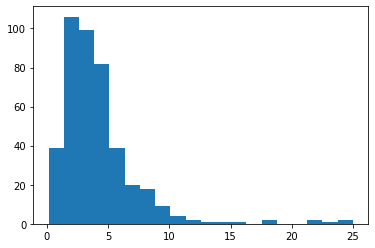

In [46]:
plt.hist(mroz['wage'].dropna(),bins=20)
pass

In [47]:
thresh = np.log(mroz['wage'].min()*0.5)  # 左切断の下限

formula = 'lwage ~ 1 + educ + exper + expersq'

res_trunc = Truncreg.from_formula(formula, left=thresh,
                                  data=mroz.dropna(subset=['lwage'])).fit()

print(res.summary().tables[1])

NameError: name 'Truncreg' is not defined

この推定では，`wage`の最小値の50%の値の対数を下限の値に設定している。`wage=0`を下限にしてもよいが，その場合，`np.log(0)`はマイナス無限になり，通常の最尤推定と同じになる。切断回帰推定を使っても結果は変わらない。即ち，選択バイアスが大きな問題ではないことを示唆している。

---
第１段階推定では`Probit`モデルを使っているが，以下では不均一分散に関して検定を行う。

In [48]:
het_test_probit(res_heckit.select_res)

NameError: name 'het_test_probit' is not defined

帰無仮説は棄却できない。